# fm0

seems like FM0 is a good idea with ASK: transition on every clock cycle, with an extra transition for 0. this is used for other RFID applications.

basic idea: demod. find transitions. find time between transitions. if short short, 0. if long, 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [277]:
n_symb = 32

symb = -1 + 2 * np.random.randint(0, 2, n_symb)

In [278]:
dsymb = np.repeat(symb, 2)
dsymb[1::2] = -1

dsymb = np.insert(dsymb, 0, 1)
dsymb

array([ 1,  1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1])

In [279]:
cp = np.cumprod(dsymb)
# np.insert(cp, 0, 1)
cp

array([ 1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1,
       -1, -1,  1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,
       -1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1])

<IPython.core.display.Javascript object>


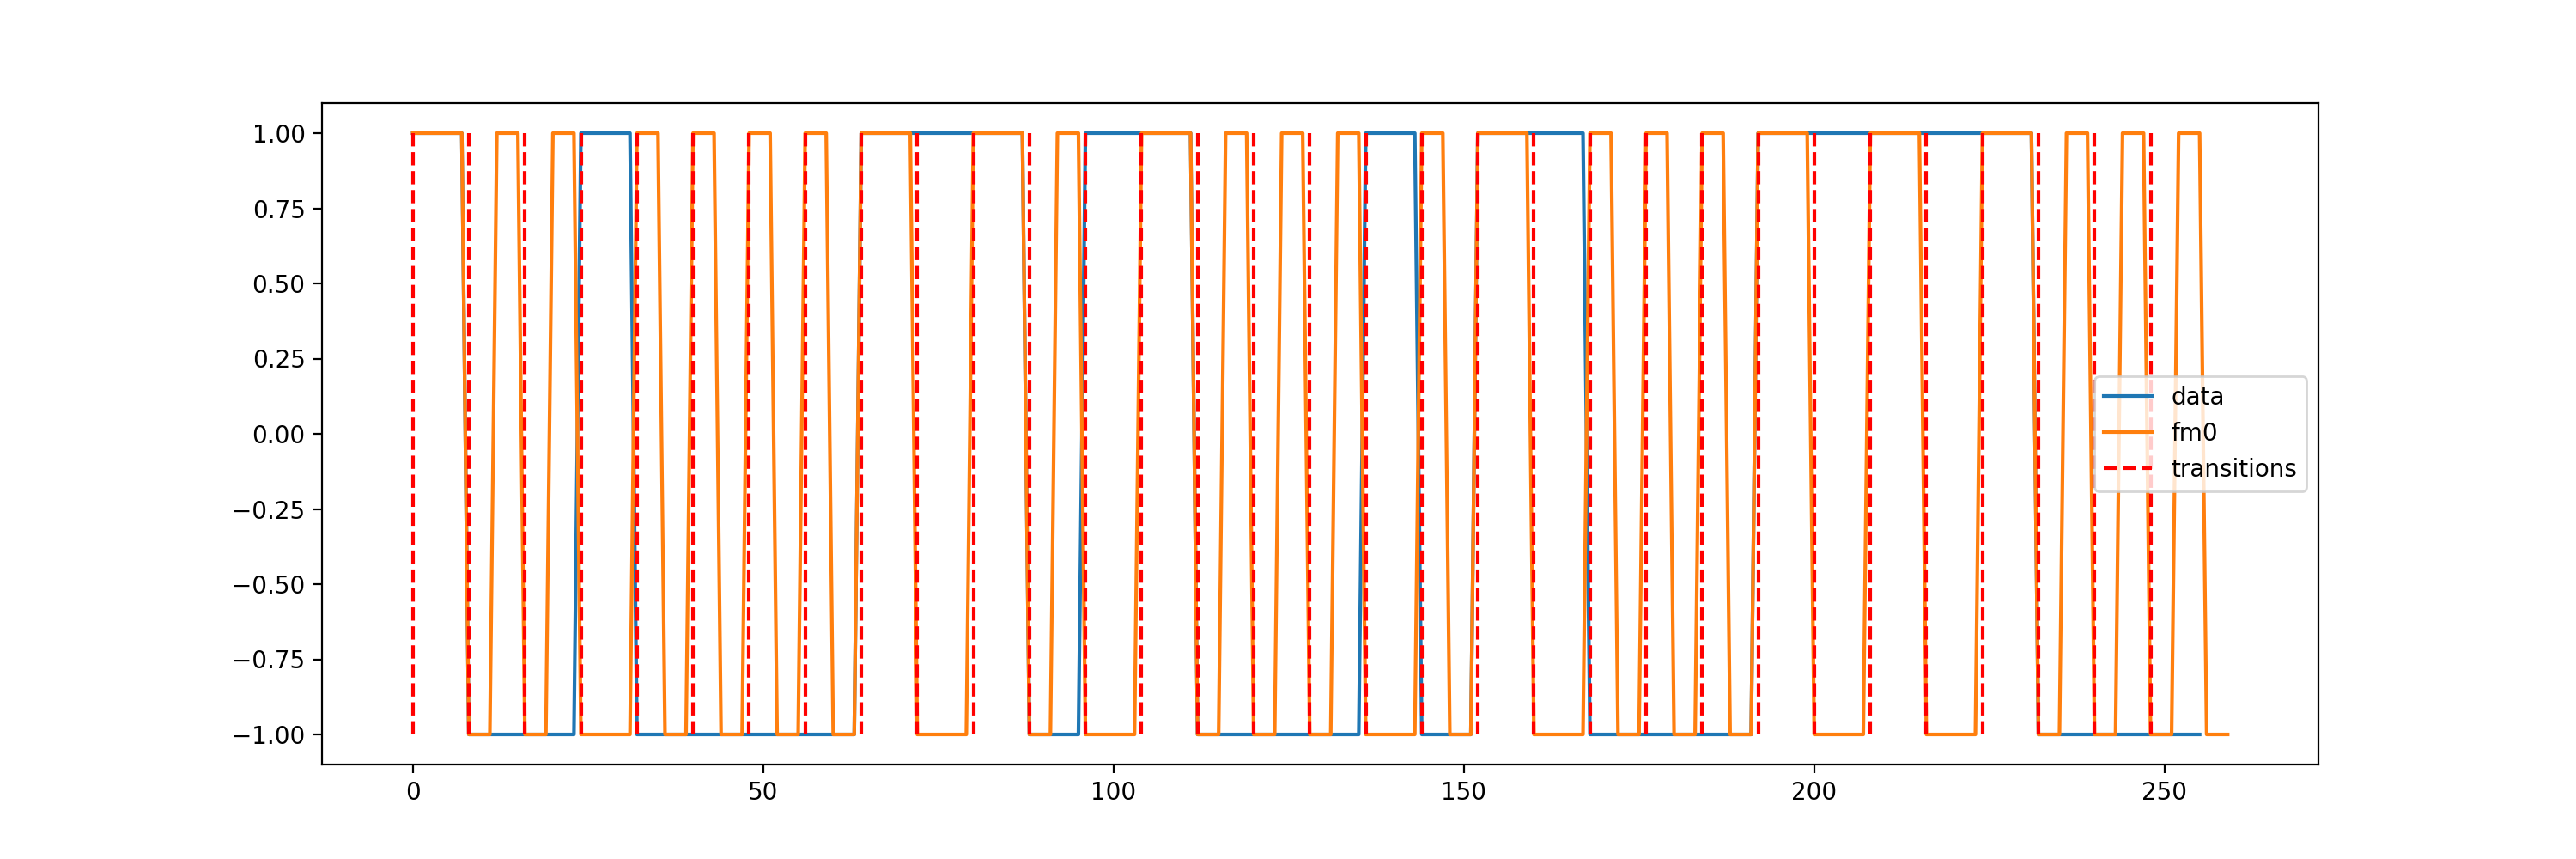

In [312]:
plt.figure(figsize=(15, 5))

plt.plot(np.repeat(symb, 4 * 2))
plt.plot(np.repeat(cp, 4))
plt.vlines(4 * 2 * np.arange(n_symb), -1, 1, linestyle='dashed', color='red')

plt.legend(['data', 'fm0', 'transitions'])



## convert to ask

In [281]:
samp_per_symb = 16
n_samp = n_symb * samp_per_symb + samp_per_symb // 2

ask_symb = np.repeat((cp + 1) // 2, samp_per_symb // 2)

## channel impairments

# noise
n = (np.random.randn(n_samp) + 1j*np.random.randn(n_samp)) / np.sqrt(2)
n_pwr = 0.3
r = ask_symb + n_pwr * n

# frequency offset - this won't change abs
fs = 30e3
fo = 200
Ts = 1 / fs
t = np.arange(0, Ts*len(r), Ts) # time vector
r *= np.exp(1j*2*np.pi*fo*t)

# iq offset
r += (np.random.randn() + 1j * np.random.randn())

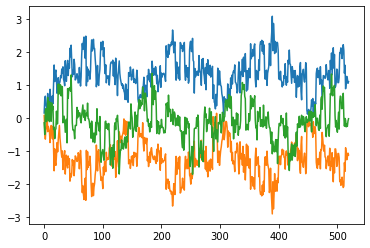

In [282]:
plt.plot(np.abs(r))
plt.plot(np.real(r))
plt.plot(np.imag(r))

## demod!

In [283]:
rx_mag = np.abs(r)

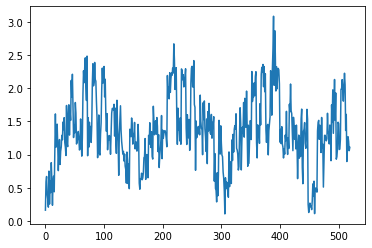

In [284]:
plt.plot(rx_mag)

In [305]:
# remove fixed IQ offset
i_off = np.mean(np.real(r))
q_off = 1j*np.mean(np.imag(r))

print(i_off, q_off)

r_corr = r - i_off - q_off

rx_mag = np.abs(r_corr)

-1.2224650872049303 (-0-0.12338497523101213j)


<IPython.core.display.Javascript object>


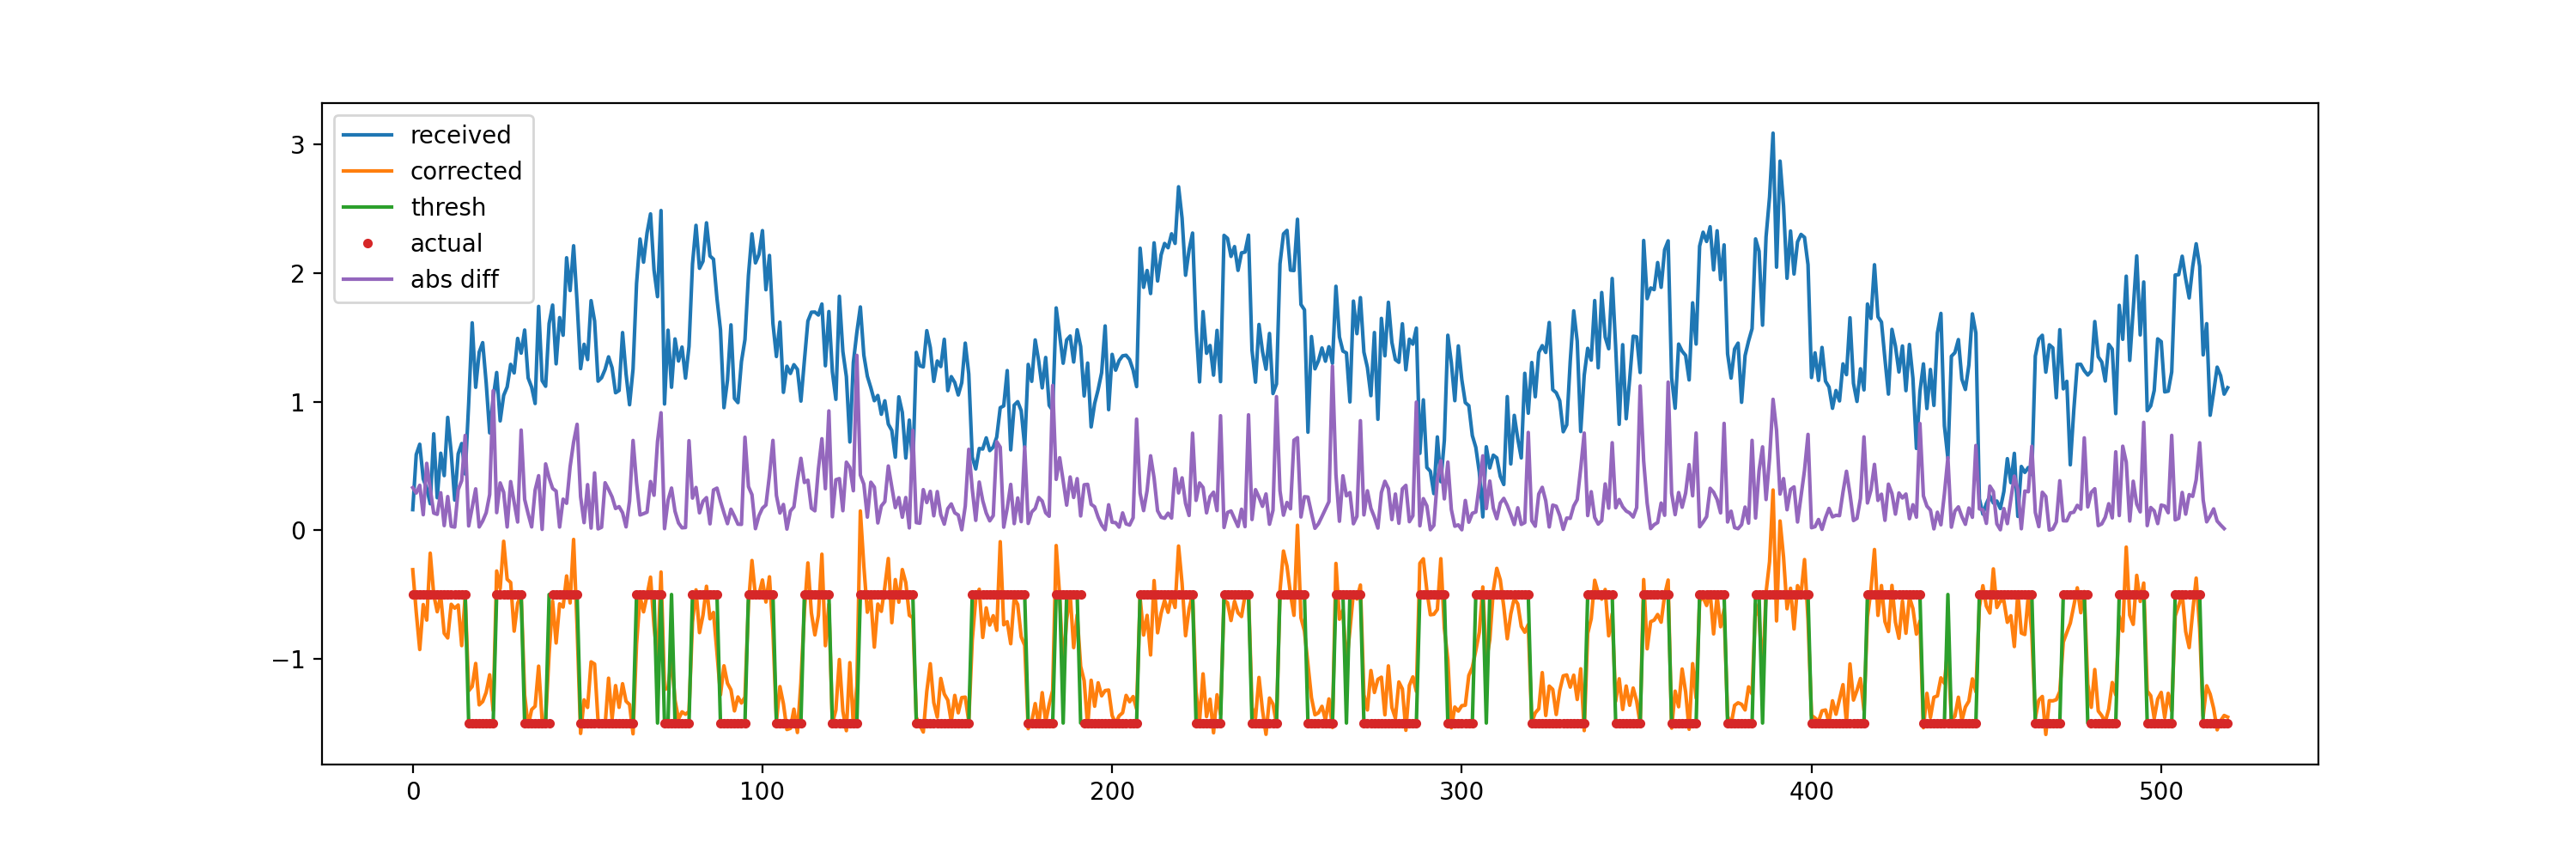

In [315]:
%matplotlib notebook
plt.figure(figsize=(15, 5))

plt.plot(np.abs(r))

midpt = np.median(rx_mag)

plt.plot(rx_mag - midpt - 1)

r_thresh = np.array(rx_mag > midpt, dtype=int)

plt.plot(r_thresh - 1.5)
plt.plot(np.repeat((cp + 1) // 2, 8) - 1.5, '.')

# maybe for later - look at transitions!
plt.plot(np.abs(np.diff(rx_mag)))

plt.legend(['received', 'corrected', 'thresh', 'actual', 'abs diff']);

In [308]:
# now we have binary samples... reverse fm0
# the short and long pulses will be the two means... proper procedure here would be to treat this as a bimodal
# distribution? but not for now
delta = np.diff(r_thresh)

# add the dummy start-of-frame index... this would eventually be a preamble or smth
delta_idx = np.append([-1], np.where(delta != 0)[0])
pulse_lens = np.diff(delta_idx)

corr_pulse = []

acc = 0

print("pulses:")
print(pulse_lens)

pulse_iter = iter(pulse_lens)

corr_pulse = []

last_p = 0

for p in pulse_iter:
#     print(p)
    
    if p == 1 and len(corr_pulse):
        # noise!
        next_p = next(pulse_iter)
        
        corr_pulse[-1] += 1 + next_p
    else:
        corr_pulse.append(p)
    
print(corr_pulse)

pulses:
[16  8  8  7  9 16  6  1  1  2  1  5  8  8  8  8  8  8 16 16 16  8  2  1
  4 17 16  8  8  8  8  8  3  1  4 16  8  8  3  1 12 16  8  8  8  8  8  8
  2  1 13 16 16  7  1  8 16  8  7  9  8  8  8]
[16, 8, 8, 7, 9, 16, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 8, 7, 17, 16, 8, 8, 8, 8, 8, 8, 16, 8, 8, 16, 16, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 8, 7, 9, 8, 8, 8]


## decoding?
i'm not sure what the best decoding scheme is here. if we see a noisy blip, that cuts up our signal.

example:

we send `16 8 8`

we receive `8 1 7 8 8`

that LOOKS like `8 8 8 8`, but of course is not. My idea is that when we see a pulse that is CLEARLY TOO SHORT - say, less than 7, we assume it is caused by noise. Or maybe, we assume that all REALLY small blips are caused by noise (1 or 2). Then, what do we do? We ASSUME that any SMALL BLIP is surrounded by pulses that were actually part of it. We need a 2-lookahead. So `8 1 7` - we see the `1`, note the blip, and when we see the 7, combined both. Note that we CANNOT just combine two - these are PULSE TRANSITIONS so a blip implicates TWO errors.

ALSO need to ensure alignment. This can probably be accomplished with a certain preamble, i.e. `1010` = `long short short long short short`.

In [309]:
# short short is 0. long is 1.
#
# will need to tune these thresholds
decode_symb = []

mid_pulse = (long_pulse + short_pulse) // 2

pulses = corr_pulse

while len(pulses):
    # short short = 0
    if np.max(np.subtract(pulses[:2], (short_pulse, short_pulse))) <= 1:
        decode_symb.append(0)
        pulses = pulses[2:]
    
    # long = 1
    elif abs(pulses[0] - long_pulse) <= 2:
        decode_symb.append(1)
        pulses = pulses[1:]
    
    # otherwise... best guess
    elif pulses[0] < mid_pulse:
        decode_symb.append(0)
        pulses = pulses[2:]
    else:
        decode_symb.append(1)
        pulses = pulses[1:]

In [310]:
symb_bin = (symb + 1) // 2
print(list(symb_bin))
print(decode_symb)

[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0]


In [311]:
100 * np.mean(symb_bin[:len(decode_symb)] == decode_symb[:len(symb_bin)])

100.0